#### NumberLink: Using Genetic Algorithm and Wisdom of Crowds

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

#### Global Variables

##### Think of each tuple in the LIST as the number in Numberlink, and the tuples inside each tuple as the start and end points of the number.

##### So in this example:

```python
pairs = [((0, 0), (4, 4)), ((1, 1), (3, 3))]

1 - - - -
- 2 - - -
- - - - -
- - - 2 -
- - - - 1


In [2]:
grid_size_static = 10
# Static pairs of coordinates (start, end)
pairs_static = [
    ((0, 0), (4, 4)),  # Pair 1 - will likely need to curve to avoid others
    ((1, 0), (1, 6)),  # Pair 2 - short diagonal near top-left
    ((2, 2), (0, 5)),  # Pair 3 - vertical line that blocks easy paths
    ((7, 2), (7, 7)),  # Pair 4 - crosses the grid horizontally
    ((8, 4), (8, 9))   # Pair 5 - forces others to route around it
]
grid_static = np.zeros((grid_size_static, grid_size_static), dtype=int)
    
# Place the pairs on the grid for visualization (optional)
for i, (start, end) in enumerate(pairs_static, start=1):
    grid_static[start] = i
    grid_static[end] = i



grid_size_random = 20
# We have 10 pairs of start and end points (i.e. 10 number pairs to find paths between)
pairs_random = [((random.randint(0, grid_size_random-1), random.randint(0, grid_size_random-1)),
          (random.randint(0, grid_size_random-1), random.randint(0, grid_size_random-1)))
         for _ in range(10)]


population_size = 400 # Idk if this is a good number but let's assume hehe
mutation_rate = 0.06 # need to experiment with this
generations = 2000 # x generations 
stopping_threshold = 700  # Number of generations with no improvement (i.e. our early stopping condition to prevent running forever lmao)
expert_percentage = 0.4 # x% of the population will be experts
num_elites = 5

DIRECTIONS = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up, makes sense? :D

#### Generate a random path given a start and an end coordinate

In [3]:
def generate_random_path(start, end, grid_size):
    path = [start]
    current_position = start
    max_attempts = 100  # Prevent infinite loops
    attempt = 0
    
    while current_position != end and attempt < max_attempts:
        possible_moves = []
        for d in DIRECTIONS:
            next_position = (current_position[0] + d[0], current_position[1] + d[1])
            if 0 <= next_position[0] < grid_size and 0 <= next_position[1] < grid_size:
                # Prefer moves that get closer to the end point
                manhattan_dist = abs(next_position[0] - end[0]) + abs(next_position[1] - end[1])
                possible_moves.append((next_position, manhattan_dist))
        
        if possible_moves:
            # Sort by Manhattan distance and prefer moves that get closer to target
            possible_moves.sort(key=lambda x: x[1])
            # 70% chance to pick the best move, 30% chance for random
            if random.random() < 0.7:
                current_position = possible_moves[0][0]
            else:
                current_position = random.choice(possible_moves)[0]
            path.append(current_position)
        
        attempt += 1
    
    # If we didn't reach the end, try to directly connect
    if current_position != end:
        path.append(end)
    
    return path

In [4]:
def initialize_population(population_size, pairs, grid_size):
    population = []
    for _ in range(population_size):
        individual = {}
        for i, (start, end) in enumerate(pairs):
            individual[i] = generate_random_path(start, end, grid_size)
        population.append(individual)
    return population

In [5]:
def fitness(individual, pairs, grid_size):
    grid = np.zeros((grid_size, grid_size), dtype=int)
    overlap_penalties = 0
    path_efficiency_score = 0
    
    # First check for overlaps (primary objective)
    for path_id, path in individual.items():
        for pos in path:
            if grid[pos[0], pos[1]] == 0:
                grid[pos[0], pos[1]] = path_id + 1
            else:
                # Heavy penalty for overlaps
                overlap_penalties += 10
    
    # If no overlaps, reward shorter paths (secondary objective)
    if overlap_penalties == 0:
        for path_id, path in individual.items():
            start, end = pairs[path_id]
            optimal_distance = abs(end[0] - start[0]) + abs(end[1] - start[1])  # Manhattan distance
            actual_distance = len(path) - 1  # -1 because path includes start point
            
            # Small reward for being close to optimal path length
            path_efficiency = optimal_distance / actual_distance if actual_distance > 0 else 0
            path_efficiency_score += path_efficiency
            
        return path_efficiency_score
    
    # If there are overlaps, return negative score
    return -overlap_penalties

In [6]:
def single_point_crossover(parent1, parent2, pairs):
    crossover_point = random.randint(0, len(pairs) - 1)
    child = {}
    for i in range(len(pairs)):
        if i <= crossover_point:
            child[i] = parent1[i]
        else:
            child[i] = parent2[i]
    return child

In [7]:
def mutate(individual, mutation_rate, pairs, grid_size):
    for i in range(len(pairs)):
        if random.random() < mutation_rate:
            individual[i] = generate_random_path(pairs[i][0], pairs[i][1], grid_size)
    return individual

In [8]:
def selection(population, pairs, grid_size, population_size):
    population_sorted = sorted(population, key=lambda i: fitness(i, pairs, grid_size), reverse=True)
    return population_sorted[:population_size // 2]

In [9]:
def get_best_individual(population, pairs, grid_size):
    best_individual = population[0]
    best_fitness_score = fitness(best_individual, pairs, grid_size)
    for individual in population:
        current_fitness = fitness(individual, pairs, grid_size)
        if current_fitness > best_fitness_score:
            best_individual = individual
            best_fitness_score = current_fitness
    return best_individual

In [10]:
def select_parent(population, pairs, grid_size):
    # Randomly sample 5 individuals from the population
    sample = random.sample(population, 5)  # Adjust sample size as needed
    # Evaluate fitness for the sampled individuals
    sampled_fitness = [fitness(individual, pairs, grid_size) for individual in sample]
    # Select the individual with the best fitness
    best_index = sampled_fitness.index(max(sampled_fitness))  # Max since we want the highest fitness
    return sample[best_index]

In [11]:
def aggregate_expert_solutions(experts, pairs, grid_size):
    # Create a grid to count occurrences of paths
    path_counts = defaultdict(int)
    
    # Count how many times each path is used in expert solutions
    for expert in experts:
        for path_id, path in expert.items():
            for pos in path:
                path_counts[pos] += 1  # Increment count for each position in the path

    # Create a new individual based on the most common paths
    new_individual = {}
    for path_id in range(len(pairs)):
        # Create a new path by taking the most common positions
        common_path = [pos for pos, count in path_counts.items() if count > 0]  # Adjust threshold as necessary
        if common_path:
            new_individual[path_id] = random.sample(common_path, len(common_path))  # Randomly sample if needed

    return new_individual

In [12]:
def replace_with_expert_solution(population, experts, pairs, grid_size):
    # Get the worst individual in the current population
    worst_index = min(range(len(population)), key=lambda i: fitness(population[i], pairs, grid_size))
    # Select a solution from experts
    expert_solution = random.choice(experts)  # Choose a random expert solution
    # Replace the worst individual with the expert solution
    population[worst_index] = expert_solution

In [13]:
def genetic_algorithm_wisdom(population, generations, mutation_rate, pairs, grid_size, stopping_threshold, expert_percentage):
    best_fitness = -float('inf')
    generations_no_improvement = 0

    for generation in range(generations):
        new_population = []
        
        #Identify elite individuals by picking the top 'n' performers (check global variable :D)
        elites = sorted(population, key=lambda i: fitness(i, pairs, grid_size), reverse=True)[:num_elites]
        new_population.extend(elites)  # Start with elites
        
        new_population = list(elites)  #Start with the elites

        #Create expert group
        num_experts = int(expert_percentage * len(population))
        experts = sorted(population, key=lambda i: fitness(i, pairs, grid_size), reverse=True)[:num_experts]

        # Generate new individuals through crossover
        while len(new_population) < len(population):  # Maintain population size
            parent1 = select_parent(population, pairs, grid_size)  # Select the first parent
            parent2 = select_parent(population, pairs, grid_size)  # Select the second parent
            
            while parent2 == parent1:  # Ensure parents are not the same
                parent2 = select_parent(population, pairs, grid_size)

            # Crossover and mutation
            child = single_point_crossover(parent1, parent2, pairs)
            child = mutate(child, mutation_rate, pairs, grid_size)
            
            ###### WISDOM OF THE CROWD ###### UNCOMMENT THIS CODE LATER ON HMMMMGEEEEE############
            # # Aggregate expert solutions and mix them into the child
            # aggregated_solution = aggregate_expert_solutions(experts, pairs, grid_size)
            # for path_id in aggregated_solution:
            #     if path_id in child:
            #         child[path_id] = aggregated_solution[path_id]  # Merge aggregated paths

            new_population.append(child)

        # THIS IS TEMPORARY, REPLACE WITH WISDOM OF THE CROWD LATER ON BY UNCOMMENTING ABOVE AND COMMENTING THIS HEHEHEHEH
        replace_with_expert_solution(new_population, experts, pairs, grid_size)
        
        population = new_population  # Update the population
        
        # Evaluate fitness and update best individual
        current_best_individual = get_best_individual(population, pairs, grid_size)
        current_best_fitness = fitness(current_best_individual, pairs, grid_size)
        
        # Print the fitness for the current generation
        print(f"Generation {generation + 1}: Best Fitness = {current_best_fitness}")

        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            generations_no_improvement = 0
        else:
            generations_no_improvement += 1
        
        if generations_no_improvement >= stopping_threshold:
            print(f"Stopping early at generation {generation + 1} due to no improvement for {stopping_threshold} generations.")
            break
            
    return current_best_individual

In [14]:
def plot_this_shit(best_individual, pairs, grid_size):
    plt.figure(figsize=(8, 8))
    
    # Create a blank grid
    for path_id, path in best_individual.items():
        # Extract the x and y coordinates of the path
        x_coords, y_coords = zip(*path)
        plt.plot(y_coords, x_coords, linewidth=2)  # Draw the path
    
    # Plot numbers at start and end points based on success
    for i, (start, end) in enumerate(pairs):
        # Check if the path for the current pair reaches the end point
        if end in best_individual[i]:  # If the end point is in the path
            color = 'red'  # Success
        else:
            color = 'green'  # Failure
        
        # Annotate the grid with numbers, colored based on success
        plt.text(start[1], start[0], str(i + 1), color=color, fontsize=12, ha='center', va='center')  # Number at start
        plt.text(end[1], end[0], str(i + 1), color=color, fontsize=12, ha='center', va='center')    # Number at end

    plt.title("Best Solution Visualization")
    plt.xlim(-0.5, grid_size - 0.5)  # Set x-axis limits
    plt.ylim(grid_size - 0.5, -0.5)  # Invert y-axis
    plt.xticks(range(grid_size))
    plt.yticks(range(grid_size))
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')  # Maintain aspect ratio
    plt.show()

In [15]:
def initialize_static_problem():
    grid_size = 10
    # Static pairs of coordinates (start, end)
    pairs = [
        ((0, 0), (9, 9)),  # Pair 1
        ((0, 9), (9, 0)),  # Pair 2
        ((2, 2), (7, 7)),  # Pair 3
        ((3, 8), (8, 3)),  # Pair 4
        ((1, 5), (5, 1))   # Pair 5
    ]
    
    # Initialize grid with zeros
    grid = np.zeros((grid_size, grid_size), dtype=int)
    
    # Place the pairs on the grid for visualization (optional)
    for idx, (start, end) in enumerate(pairs, start=1):
        grid[start] = idx
        grid[end] = idx
    
    return grid, pairs

#### Main

Starting Genetic Algorithm...
Run 1/1
Generation 1: Best Fitness = -30
Generation 2: Best Fitness = -30
Generation 3: Best Fitness = -20
Generation 4: Best Fitness = -20
Generation 5: Best Fitness = -20
Generation 6: Best Fitness = -20
Generation 7: Best Fitness = -20
Generation 8: Best Fitness = -20
Generation 9: Best Fitness = -20
Generation 10: Best Fitness = -20
Generation 11: Best Fitness = -20
Generation 12: Best Fitness = -20
Generation 13: Best Fitness = -20
Generation 14: Best Fitness = -20
Generation 15: Best Fitness = -20
Generation 16: Best Fitness = -20
Generation 17: Best Fitness = -20
Generation 18: Best Fitness = -20
Generation 19: Best Fitness = -20
Generation 20: Best Fitness = -20
Generation 21: Best Fitness = -20
Generation 22: Best Fitness = -20
Generation 23: Best Fitness = -20
Generation 24: Best Fitness = -20
Generation 25: Best Fitness = -20
Generation 26: Best Fitness = -20
Generation 27: Best Fitness = -20
Generation 28: Best Fitness = -20
Generation 29: Best

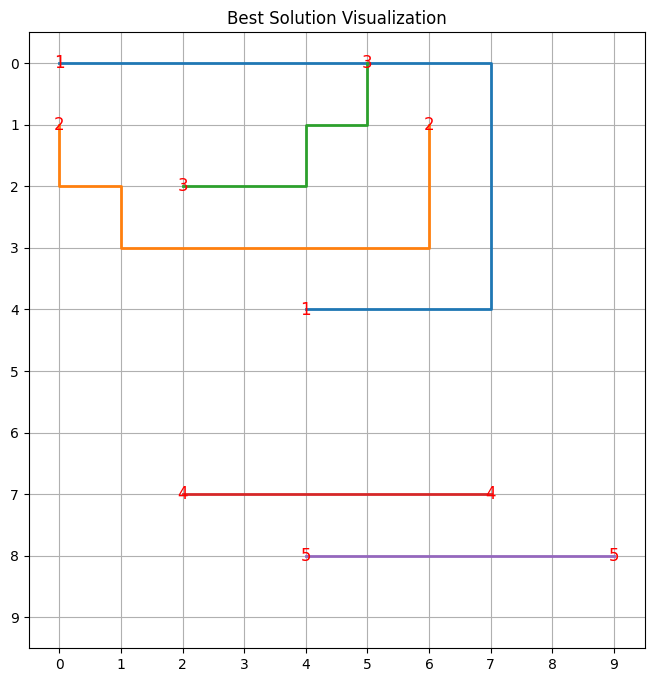

Starting Genetic Algorithm...
Run 1/1
Generation 1: Best Fitness = -450
Generation 2: Best Fitness = -360
Generation 3: Best Fitness = -340
Generation 4: Best Fitness = -320
Generation 5: Best Fitness = -290
Generation 6: Best Fitness = -250
Generation 7: Best Fitness = -250
Generation 8: Best Fitness = -230
Generation 9: Best Fitness = -200
Generation 10: Best Fitness = -200
Generation 11: Best Fitness = -190
Generation 12: Best Fitness = -190
Generation 13: Best Fitness = -180
Generation 14: Best Fitness = -180
Generation 15: Best Fitness = -160
Generation 16: Best Fitness = -160
Generation 17: Best Fitness = -160
Generation 18: Best Fitness = -160
Generation 19: Best Fitness = -160
Generation 20: Best Fitness = -160
Generation 21: Best Fitness = -160
Generation 22: Best Fitness = -160
Generation 23: Best Fitness = -160
Generation 24: Best Fitness = -160
Generation 25: Best Fitness = -160
Generation 26: Best Fitness = -160
Generation 27: Best Fitness = -160
Generation 28: Best Fitnes

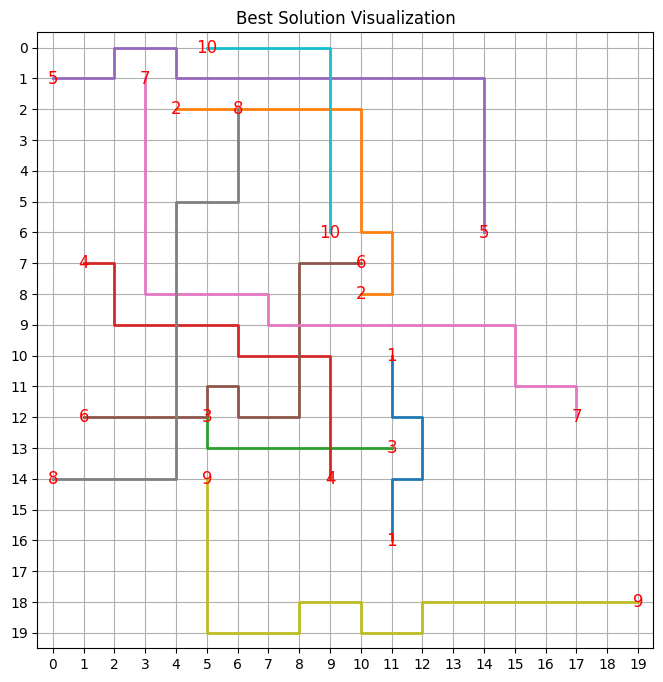

In [16]:
#Static problem

population = initialize_population(population_size, pairs_static, grid_size_static)
num_runs = 1  # Number of runs to perform (testing purposes)
best_overall_individual = None
best_overall_fitness = -float('inf')  # Initialize to a very low number

print("Starting Genetic Algorithm...")
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    
    # Run the genetic algorithm
    current_best_individual = genetic_algorithm_wisdom(population, generations, mutation_rate, pairs_static, grid_size_static, stopping_threshold, expert_percentage)
    
    # Evaluate the fitness of the current best individual
    current_best_fitness = fitness(current_best_individual, pairs_static, grid_size_static)
    
    print(f"Best Fitness from Run {run + 1}: {current_best_fitness}")
    
    # Check if the current run has the best fitness
    if current_best_fitness > best_overall_fitness:
        best_overall_fitness = current_best_fitness
        best_overall_individual = current_best_individual

# After all runs, visualize the best solution found
print(f"Best Overall Fitness: {best_overall_fitness}")
plot_this_shit(best_overall_individual, pairs_static, grid_size_static)

#Random Problem Initialization

#Static problem

population = initialize_population(population_size, pairs_random, grid_size_random)
num_runs = 1  # Number of runs to perform (testing purposes)
best_overall_individual = None
best_overall_fitness = -float('inf')  # Initialize to a very low number

print("Starting Genetic Algorithm...")
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    
    # Run the genetic algorithm
    current_best_individual = genetic_algorithm_wisdom(population, generations, mutation_rate, pairs_random, grid_size_random, stopping_threshold, expert_percentage)
    
    # Evaluate the fitness of the current best individual
    current_best_fitness = fitness(current_best_individual, pairs_random, grid_size_random)
    
    print(f"Best Fitness from Run {run + 1}: {current_best_fitness}")
    
    # Check if the current run has the best fitness
    if current_best_fitness > best_overall_fitness:
        best_overall_fitness = current_best_fitness
        best_overall_individual = current_best_individual

# After all runs, visualize the best solution found
print(f"Best Overall Fitness: {best_overall_fitness}")
plot_this_shit(best_overall_individual, pairs_random, grid_size_random)

